In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchmetrics.regression import MeanSquaredError, R2Score

In [30]:
DATA_PATH = "../Data/뜸부기/"

In [31]:
train_data = pd.read_csv(DATA_PATH + 'train.csv')
train_data

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7494,TRAIN_7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


In [32]:
test_data = pd.read_csv(DATA_PATH + 'test.csv')
test_data.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0


In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [34]:
train_data['제조사'].value_counts()

제조사
H사    1237
B사    1169
K사    1164
A사    1142
T사    1109
P사    1071
V사     605
Name: count, dtype: int64

In [35]:
train_data['모델'][train_data['제조사'] == 'H사'].value_counts()

모델
ION6     379
KNE      365
ION5     353
IONIQ    140
Name: count, dtype: int64

In [36]:
train_data['차량상태'].value_counts()

차량상태
Brand New     3380
Nearly New    2059
Pre-Owned     2058
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

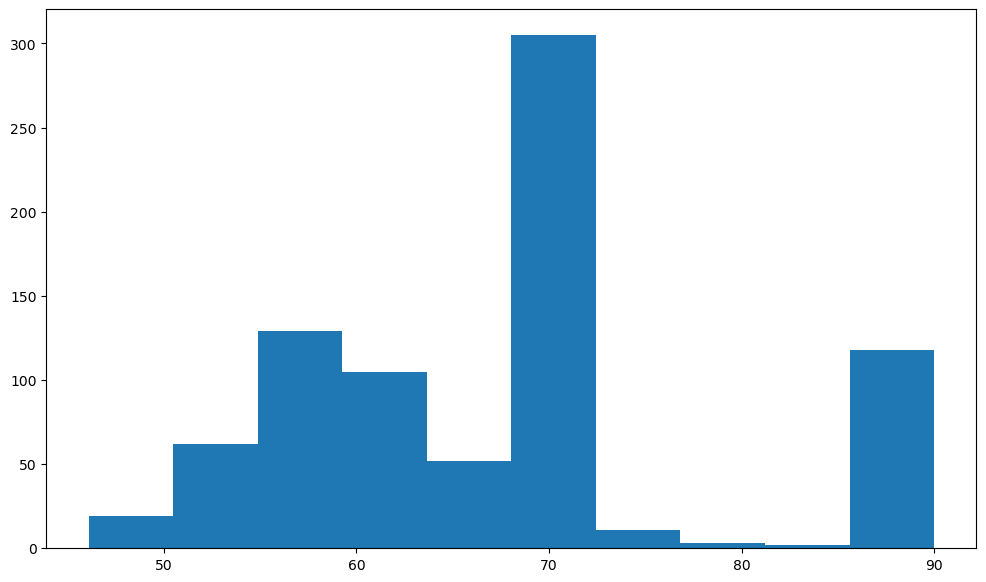

In [37]:
plt.figure(figsize = (12, 7))
plt.hist(train_data['배터리용량'][train_data['제조사'] == 'H사'])
plt.show

In [38]:
train_data['배터리용량'][train_data['제조사'] == 'H사'].mean()

67.39844044665013

In [39]:
train_data['배터리용량'] = train_data['배터리용량'].fillna(train_data.groupby('제조사')['배터리용량'].transform('mean'))

In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     7497 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [41]:
pre_train_data = pd.get_dummies(train_data, columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력'], drop_first = True)
pre_train_data

,ID,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원),제조사_B사,제조사_H사,제조사_K사,제조사_P사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,TRAIN_0000,86.077000,13642,0,2,159.66,False,False,False,True,...,True,False,False,False,False,True,False,False,False,False
1,TRAIN_0001,56.000000,10199,6,0,28.01,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
2,TRAIN_0002,91.200000,2361,7,0,66.27,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,TRAIN_0003,78.775598,21683,3,0,99.16,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,TRAIN_0004,61.018000,178205,1,0,62.02,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,67.398440,3773,10,0,35.95,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,TRAIN_7493,46.000000,135411,2,0,23.40,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,TRAIN_7494,75.265280,1363,2,0,120.00,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7495,TRAIN_7495,56.000000,39445,6,2,24.00,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [42]:
train_target = pre_train_data['가격(백만원)']

train_feature_col = pre_train_data.columns.to_list()
train_feature_col.remove('가격(백만원)')
train_feature_col.remove('ID')

train_feature = pre_train_data[train_feature_col]

train_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,86.077000,13642,0,2,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
1,56.000000,10199,6,0,False,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,91.200000,2361,7,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,78.775598,21683,3,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,61.018000,178205,1,0,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,67.398440,3773,10,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,46.000000,135411,2,0,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,75.265280,1363,2,0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7495,56.000000,39445,6,2,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [68]:
pre_train_data[pre_train_data.columns[1:]].corr()

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
배터리용량,1.000000,-0.428026,0.257751,0.010284,0.443125,-0.230966,-0.067375,-0.389236,1.832923e-01,0.283940,...,0.165800,0.241672,-0.270635,-0.082892,-0.022729,-0.058224,-0.434942,-0.259245,-0.150058,-3.825245e-03
주행거리(km),-0.428026,1.000000,-0.664071,-0.089586,-0.035488,0.004711,0.006593,-0.003576,7.806246e-03,0.003311,...,-0.001223,0.000660,0.081379,0.081962,-0.162395,-0.152557,0.872790,-0.001287,0.003981,-6.162968e-04
보증기간(년),0.257751,-0.664071,1.000000,0.035294,-0.349962,-0.015885,0.186374,0.242283,-4.093352e-01,-0.008176,...,-0.228721,-0.011228,-0.096341,-0.106576,0.185027,-0.070805,-0.682035,0.185970,-0.013992,-8.011223e-03
연식(년),0.010284,-0.089586,0.035294,1.000000,-0.058455,-0.007163,0.060471,-0.010986,-1.425487e-02,-0.011050,...,-0.015516,-0.016391,0.049374,0.024510,-0.088682,0.596915,-0.202109,0.061349,-0.013776,-1.044580e-02
가격(백만원),0.443125,-0.035488,-0.349962,-0.058455,1.000000,-0.083507,-0.376286,-0.369152,7.760593e-01,0.088937,...,0.600937,0.036292,-0.247178,0.003572,0.109590,-0.030800,-0.045296,-0.421124,-0.084678,4.626858e-03
제조사_B사,-0.230966,0.004711,-0.015885,-0.007163,-0.083507,1.000000,-0.191061,-0.184266,-1.754682e-01,-0.179084,...,-0.098625,-0.099178,0.543548,0.562494,0.527855,0.002424,-0.003215,-0.193829,0.651632,9.085758e-04
제조사_H사,-0.067375,0.006593,0.186374,0.060471,-0.376286,-0.191061,1.000000,-0.190577,-1.814772e-01,-0.185217,...,-0.102003,-0.102574,-0.103851,-0.107470,-0.100852,0.007461,0.029337,0.283789,-0.180686,-1.478183e-02
제조사_K사,-0.389236,-0.003576,0.242283,-0.010986,-0.369152,-0.184266,-0.190577,1.000000,-1.750234e-01,-0.178630,...,-0.098375,-0.098926,-0.100157,-0.103649,-0.097266,-0.002215,0.002039,0.555571,-0.174260,-4.493222e-04
제조사_P사,0.183292,0.007806,-0.409335,-0.014255,0.776059,-0.175468,-0.181477,-0.175023,1.000000e+00,-0.170101,...,0.562070,-0.094203,-0.095375,-0.098700,-0.092622,-0.006954,0.000854,-0.184106,-0.165940,7.020864e-18
제조사_T사,0.283940,0.003311,-0.008176,-0.011050,0.088937,-0.179084,-0.185217,-0.178630,-1.701013e-01,1.000000,...,-0.095609,-0.096144,-0.097341,-0.100734,-0.094530,-0.012272,-0.004573,-0.187900,0.131135,-3.126137e-03


In [44]:
scaling_target = pre_train_data.columns[1:5]
scaling_target

Index(['배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)'], dtype='object')

In [45]:
test_data['배터리용량'] = test_data['배터리용량'].fillna(train_data.groupby('제조사')['배터리용량'].transform('mean'))

In [46]:
pre_test_data = pd.get_dummies(test_data, columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력'], drop_first = True)
pre_test_data

,ID,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,TEST_000,76.093000,14057,2,0,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,TEST_001,90.000000,7547,8,0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,TEST_002,78.775598,7197,7,0,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,True
3,TEST_003,68.479000,10357,7,1,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,TEST_004,62.344547,7597,10,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,64.683000,117298,2,0,False,False,False,True,False,...,True,False,False,False,False,False,True,False,False,False
842,TEST_842,55.547000,72308,0,0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
843,TEST_843,55.547000,124537,0,0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
844,TEST_844,69.646000,15629,4,0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [47]:
test_feature_col = pre_test_data.columns.to_list()
test_feature_col.remove('ID')

test_feature = pre_test_data[train_feature_col]

test_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,76.093000,14057,2,0,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
1,90.000000,7547,8,0,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,78.775598,7197,7,0,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,True
3,68.479000,10357,7,1,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,62.344547,7597,10,0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,64.683000,117298,2,0,False,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
842,55.547000,72308,0,0,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
843,55.547000,124537,0,0,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
844,69.646000,15629,4,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [48]:
for col in scaling_target:
    rb_scaler = RobustScaler()
    rb_scaler.fit(train_feature[col].values.reshape(-1, 1))
    train_feature[col] = rb_scaler.transform(train_feature[col].values.reshape(-1, 1))
    test_feature[col] = rb_scaler.transform(test_feature[col].values.reshape(-1, 1))

C:\Users\DAEG\AppData\Local\Temp\ipykernel_9348\3171256708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_feature[col] = rb_scaler.transform(train_feature[col].values.reshape(-1, 1))
C:\Users\DAEG\AppData\Local\Temp\ipykernel_9348\3171256708.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_feature[col] = rb_scaler.transform(test_feature[col].values.reshape(-1, 1))
C:\Users\DAEG\AppData\Local\Temp\ipykernel_9348\3171256708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [49]:
train_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,0.946525,-0.066127,-0.833333,2.0,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
1,-0.577609,-0.127843,0.166667,0.0,False,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,1.206130,-0.268342,0.333333,0.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0.576531,0.078011,-0.333333,0.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,-0.323325,2.883718,-0.666667,0.0,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,0.000000,-0.243032,0.833333,0.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,-1.084353,2.116622,-0.500000,0.0,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,0.398647,-0.286232,-0.500000,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7495,-0.577609,0.396401,0.166667,2.0,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [50]:
train_target = pd.DataFrame(train_target)
train_target

,가격(백만원)
0,159.66
1,28.01
2,66.27
3,99.16
4,62.02
...,...
7492,35.95
7493,23.40
7494,120.00
7495,24.00


In [51]:
class CustomDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = self.featureDF.shape[0]
        self.n_cols = self.featureDF.shape[1]
    
    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].to_numpy().astype(np.float32))
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].to_numpy().astype(np.float32))

        return featureTS, targetTS

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, input_size, n_layers, dropout,
                 bidirectional):
        super().__init__()

        self.model = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_dim,
            num_layers = n_layers,
            dropout = dropout,
            bidirectional = bidirectional,
            batch_first = True
        )

        if bidirectional:
            self.linear = nn.Linear(hidden_dim * 2, 1)
        
        else:
            self.linear = nn.Linear(hidden_dim, 1)

        # 성능에 따라 추가
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        output, _ = self.model(inputs)
        logits = self.linear(output)

        return logits

In [53]:
def testing(featureDF, targetDF, model):
    featureTS = torch.FloatTensor(featureDF.to_numpy().astype(np.float32)).to(DEVICE)
    targetTS = torch.FloatTensor(targetDF.to_numpy().astype(np.float32)).to(DEVICE)

    model.eval()

    with torch.no_grad():
        pre_val = model(featureTS)
        mse_loss_val = MSEloss(pre_val, targetTS)
        score_val = R2score(pre_val, targetTS)

    return mse_loss_val, score_val, pre_val

In [54]:
def training(model, featureDF, targetDF, optimizer, EPOCH, scheduler, DEVICE, k_folds = 5):
    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    LIMIT_VALUE = 10
    
    MSE_LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    kfold = KFold(n_splits = k_folds, shuffle = True, random_state = 7)

    fold = 1
    
    for train_idx, val_idx in kfold.split(featureDF):
        print(f'Fold {fold}/{k_folds}')

        X_train, X_val = featureDF.iloc[train_idx], featureDF.iloc[val_idx]
        y_train, y_val = targetDF.iloc[train_idx], targetDF.iloc[val_idx]

        train_dataset = CustomDataset(X_train, y_train)
        val_dataset = CustomDataset(X_val, y_val)

        trainDL = DataLoader(train_dataset, batch_size = 32, shuffle = True)
        valDL = DataLoader(val_dataset, batch_size = 32)

        for epoch in range(1, EPOCH + 1):
            model.train()
            
            mse_loss_total, score_total = 0, 0

            for featureTS, targetTS in trainDL:
                featureTS = featureTS.to(DEVICE)
                targetTS = targetTS.to(DEVICE)

                pre_y = model(featureTS)
                mse_loss = MSEloss(pre_y, targetTS)

                mse_loss_total += mse_loss.item()

                score = R2score(pre_y, targetTS)
                score_total += score.item()

                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            test_mse_loss, test_score, pre_val = testing(X_val, y_val, model)

            MSE_LOSS_HISTORY[1].append(test_mse_loss)
            SCORE_HISTORY[1].append(test_score)

            MSE_LOSS_HISTORY[0].append(mse_loss_total / len(trainDL))
            SCORE_HISTORY[0].append(score_total / len(trainDL))
            
            train_mse_loss = (mse_loss_total / len(trainDL))
            print(f'[{epoch} / {EPOCH}]\n - TRAIN LOSS : {MSE_LOSS_HISTORY[0][-1]}\n - TRAIN SCORE : {SCORE_HISTORY[0][-1]}')
            print(f'[{epoch} / {EPOCH}]\n - TEST LOSS : {MSE_LOSS_HISTORY[1][-1]}\n - TEST SCORE : {SCORE_HISTORY[1][-1]}')
            
            scheduler.step(train_mse_loss)

            if len(MSE_LOSS_HISTORY) >= 2:
                if MSE_LOSS_HISTORY[-1] >= MSE_LOSS_HISTORY[-2]: BREAK_CNT_LOSS += 1

            if BREAK_CNT_LOSS > LIMIT_VALUE:
                print(f"{epoch} EPOCH에 학습 중단")
                break
        
        fold += 1

    return MSE_LOSS_HISTORY, SCORE_HISTORY

In [55]:
train_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,0.946525,-0.066127,-0.833333,2.0,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
1,-0.577609,-0.127843,0.166667,0.0,False,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,1.206130,-0.268342,0.333333,0.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0.576531,0.078011,-0.333333,0.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,-0.323325,2.883718,-0.666667,0.0,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,0.000000,-0.243032,0.833333,0.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,-1.084353,2.116622,-0.500000,0.0,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,0.398647,-0.286232,-0.500000,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7495,-0.577609,0.396401,0.166667,2.0,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [59]:
EPOCH = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

input_size = 35
hidden_dim  = 64
n_layers = 2
dropout = 0
bidirectional = True

lstm_model = LSTMModel(input_size = input_size, hidden_dim = hidden_dim, n_layers = n_layers,
                        dropout = dropout, bidirectional = bidirectional).to(DEVICE)

MSEloss = MeanSquaredError().to(DEVICE)
R2score = R2Score().to(DEVICE)

optimizer = optim.Adam(lstm_model.parameters(), lr = LR)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 10, verbose = True)

c:\Users\DAEG\anaconda3\envs\Project_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [60]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   가격(백만원)  7497 non-null   float64
dtypes: float64(1)
memory usage: 58.7 KB


In [61]:
mse_loss, r2_score = training(lstm_model, train_feature, train_target, optimizer, EPOCH, scheduler, DEVICE)

Fold 1/5
[1 / 100]
 - TRAIN LOSS : 3516.8901290893555
 - TRAIN SCORE : -1.771514892578125
[1 / 100]
 - TEST LOSS : 2522.71826171875
 - TEST SCORE : -0.8312773704528809
[2 / 100]
 - TRAIN LOSS : 1991.0708933079497
 - TRAIN SCORE : -0.5387086062989337
[2 / 100]
 - TEST LOSS : 1682.400390625
 - TEST SCORE : -0.22127854824066162
[3 / 100]
 - TRAIN LOSS : 1491.4794181661402
 - TRAIN SCORE : -0.15291779916337195
[3 / 100]
 - TEST LOSS : 1435.9407958984375
 - TEST SCORE : -0.04237008094787598
[4 / 100]
 - TRAIN LOSS : 1362.678069094394
 - TRAIN SCORE : -0.0489386684717016
[4 / 100]
 - TEST LOSS : 1385.6483154296875
 - TEST SCORE : -0.005861997604370117
[5 / 100]
 - TRAIN LOSS : 1340.7286178913523
 - TRAIN SCORE : -0.034720219196157254
[5 / 100]
 - TEST LOSS : 1378.8157958984375
 - TEST SCORE : -0.0009021759033203125
[6 / 100]
 - TRAIN LOSS : 1337.6514860112616
 - TRAIN SCORE : -0.0354916808453012
[6 / 100]
 - TEST LOSS : 1378.1702880859375
 - TEST SCORE : -0.0004335641860961914
[7 / 100]
 - T

In [62]:
def predict(featureDF, model, DEVICE):
    # DataFrame -> Tensor 변환
    featureTS = torch.FloatTensor(featureDF.to_numpy().astype(np.float32)).to(DEVICE)
    
    model.eval()  # 평가 모드로 전환 (dropout 등 비활성화)
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        predictions = model(featureTS)  # 예측 수행
    
    return predictions.cpu().numpy()  # 결과를 numpy로 반환


In [64]:
test_pred = predict(test_feature, lstm_model, DEVICE)

In [65]:
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
submission['가격(백만원)'] = test_pred

submission

,ID,가격(백만원)
0,TEST_000,131.806778
1,TEST_001,79.863327
2,TEST_002,66.510963
3,TEST_003,34.855656
4,TEST_004,48.753815
...,...,...
841,TEST_841,150.862991
842,TEST_842,38.983501
843,TEST_843,38.969124
844,TEST_844,58.803982


In [66]:
submission.to_csv(DATA_PATH + 'sample_submission.csv', index = False)